# PyTorch Introduction
Welcome to the PyTorch tutorial for deep learning! If you haven't already, enable a GPU for this colab instance by doing "Edit" -> "Notebook settings" -> "Hardware accelerator" drop-down -> "GPU" -> "Save".

Let's make sure we're using the right Python and PyTorch versions, and that we have a GPU at our disposal.

In [2]:
import sys
import torch
#print(f'Python version info: {sys.version}')
print(f'PyTorch version info: {torch.__version__}')
print(f'PyTorch detects a GPU: {torch.cuda.is_available()}')

PyTorch version info: 2.2.1+cu121
PyTorch detects a GPU: True


# Overview
We'll begin by doing some MNIST classification, starting from low-level operations and gradually replacing chunks using `torch` abstractions such as `torch.nn.Module`, `torch.optim.SGD`, and `torch.utils.data.DataLoader`. (Much of this content is adapted from [this tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard.) We'll then proceed to a whirlwind tour over PyTorch features that we suspect will be relevant for your homeworks for this course. Finally, we'll see some tips and tricks for debugging and getting help.

# PyTorch Basics via MNIST
### MNIST
Download MNIST.

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

Load MNIST into memory.

In [5]:
import pickle
import gzip
import numpy as np

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_val, y_val), _) = pickle.load(f, encoding="latin-1")

The data currently exists as NumPy arrays. Let's take a closer look.

training inputs: shape (50000, 784), dtype float32
training outputs: shape (50000,), dtype int64
input range: (0.0, 0.99609375)
label range: (0, 9)
label of training example 12: 3


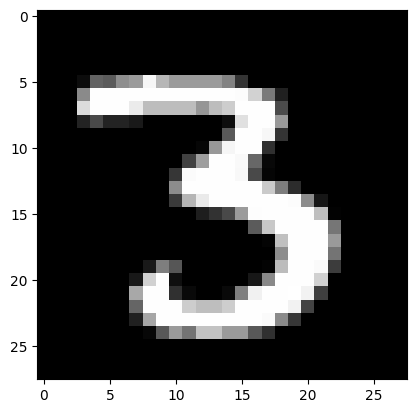

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

print(f'training inputs: shape {x_train.shape}, dtype {x_train.dtype}')
print(f'training outputs: shape {y_train.shape}, dtype {y_train.dtype}')
print(f'input range: {x_train.min(), x_train.max()}')
print(f'label range: {y_train.min(), y_train.max()}')

i_example = 12
x_train_example = x_train[i_example].reshape((28, 28))
y_train_example = y_train[i_example]
plt.imshow(x_train_example, cmap='gray')
print(f'label of training example {i_example}: {y_train_example}')

We need to convert the data into PyTorch tensors. For ease of use, tensors have some familiar attributes and methods.

In [7]:
x_train, y_train, x_val, y_val = map(torch.tensor, (x_train, y_train, x_val, y_val))
print(f'training inputs: shape {x_train.shape}, dtype {x_train.dtype}')
print(f'training outputs: shape {y_train.shape}, dtype {y_train.dtype}')
print(f'input range: {x_train.min(), x_train.max()}')
print(f'label range: {y_train.min(), y_train.max()}')

training inputs: shape torch.Size([50000, 784]), dtype torch.float32
training outputs: shape torch.Size([50000]), dtype torch.int64
input range: (tensor(0.), tensor(0.9961))
label range: (tensor(0), tensor(9))


### Bare Metal MNIST
We will first train a model for classifying MNIST digits with nothing but tensor and gradient operations. We'll later substitute out chunks of this code with the appropriate PyTorch abstractions.

To keep things simple, for this we'll use a linear model. For a single example, the model is
$$ z = W^\top x + b $$
where $W \in \mathbb{R}^{784 \times 10}$ and $b \in \mathbb{R}^{10}$ are the parameters to be learned, $x \in [0, 1]^{784}$ is the MNIST image, and $z \in \mathbb{R}^{10}$ are the logits of the categorical distribution for the label of $x$.

To obtain categorical parameters from the logits, we do
$$ p = \text{softmax}(z) = \frac{1}{\sum_j \exp(z_j)} \exp(z).$$

The label $y \in \{0, \dots, 9\}$ implicitly defines a one-hot categorical parameter vector $y' \in \{0, 1\}^{10}$, where $y$ corresponds to the index of $y'$ that is 1. The negative log-likelihood is then
$$ \text{nll}(p, y) = - \sum_{i=0}^{9} y'_i \log(p_i) = -\log(p_y)$$

Note that our implementation will assume batched inputs with a batch size of $B$. That is,
$$x_b = \begin{bmatrix} x_1^\top \\ \vdots \\ x_B^\top \end{bmatrix} \in [0, 1]^{B \times 784}.$$ We can vectorize the above operations to process all $B$ inputs at once (naively using `for` loops is much, much slower). For example, to compute the logits, we have
$$z_b = x_b W + \begin{bmatrix} b^\top \\ \vdots \\ b^\top \end{bmatrix} \in \mathbb{R}^{B \times 10}$$


In [8]:
W = torch.randn(784, 10, requires_grad=True)
b = torch.randn(10, requires_grad=True)

def logits(x_b, W, b):
    return x_b @ W + b    # @ matrix multiplication, addition is broadcasted

def log_softmax(z_b):
    return z_b - torch.logsumexp(z_b, dim=1, keepdim=True)  # combining log and softmax is more numerically stable

def negative_log_likelihood(logp_b, y_b):
    return -torch.mean(logp_b[range(y_b.shape[0]), y_b])   # indexing trick

def accuracy(logit_b, y_b):
    return (logit_b.argmax(dim=1) == y_b).float().mean().item()

Note that the `requires_grad` keyword argument/attribute determines whether a tensor is a constant or a variable.

In [9]:
print(b.requires_grad)
print(y_train.requires_grad)

True
False


### Computation Graph
Now we have the opportunity to look at some of PyTorch's core mechanics: reverse-mode automatic differentiation (a.k.a. backpropagation) on a dynamic computation graph. Let's take a batch of training data and compute the average loss over the batch.

In [10]:
batch_size = 64
x_b, y_b = x_train[:batch_size], y_train[:batch_size]

def loss_fn(W, b, x_b, y_b):
    logit_b = logits(x_b, W, b)
    logp_b = log_softmax(logit_b)
    loss = negative_log_likelihood(logp_b, y_b)
    return loss

loss = loss_fn(W, b, x_b, y_b)

Computations like the above are automagically recorded on a computation graph. Let's take a peek.

In [11]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30

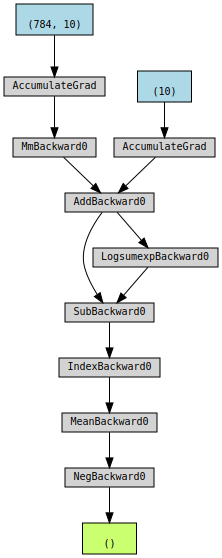

In [12]:
import torchviz
torchviz.make_dot(loss)

We can actually inspect tensors to see that each non-leaf variable tensor records its gradient function based on how it was obtained.

In [13]:
print(b.grad_fn)    # leaf variable
print(loss.grad_fn)
print(x_b.grad_fn)  # not a variable

None
None


### Using `autograd.grad` to Compute Gradients
We can now use reverse-mode automatic differentiation to compute the gradient of the loss with respect to our parameters!

In [14]:
from torch import autograd
loss = loss_fn(W, b, x_b, y_b)
W_grad, b_grad = autograd.grad(loss, inputs=(W, b))
print(b_grad)

tensor([ 0.0746, -0.0701,  0.1698, -0.0830, -0.1250,  0.1362, -0.0598, -0.0685,
         0.1545, -0.1288])


We're now ready to optimize our linear MNIST model. Each iteration consists of the following steps:
* Sample a batch of training data.
* Compute the logits from the inputs using the model parameters.
* Compute a scalar loss from the logits and labels.
* Compute the gradient of the loss with respect to the parameters.
* Update the model parameters using the gradient.

Note that the last step is done in a context manager that disables the construction of the computation graph.

To check whether our optimization was successful, we'll look at the accuracy on the training data before and after.

In [15]:
lr = 0.5
num_epochs = 2

def train(W, b):
    print(f'accuracy before: {accuracy(logits(x_train, W, b), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = logits(x_b, W, b)
            logp_b = log_softmax(logit_b)
            loss = negative_log_likelihood(logp_b, y_b)
            W_grad, b_grad = autograd.grad(loss, inputs=(W, b))

            with torch.no_grad():   # we don't need gradients for this
                W -= lr * W_grad
                b -= lr * b_grad

    print(f'accuracy after: {accuracy(logits(x_train, W, b), y_train)}')

W = torch.randn(784, 10, requires_grad=True)
b = torch.randn(10, requires_grad=True)
train(W, b)

accuracy before: 0.08083999902009964
accuracy after: 0.8863400220870972


### Using `backward` to Compute Gradients
An alternative to using `autograd.grad` is to call `backward()` on the loss tensor. This _accumulates_ gradients of leaf tensors into their `grad` attribute. (Note that with this we don't need to specify the variables we're taking the gradient with respect to, nor do we obtain the gradients as output from the function call.)

When we're done using a gradient in a `grad` attribute, we should reset it to 0, else repeated accumulations may occur. We can do this with the `Tensor` method `zero_()`. (Note that the `_` signifies that the operation modifies the tensor in-place.)

In [17]:
print('before computing gradients')
print(b.grad)

loss = loss_fn(W, b, x_b, y_b)
loss.backward()
print('after forward pass and calling backward()')
print(b.grad)

loss = loss_fn(W, b, x_b, y_b)
loss.backward()
print('after another forward pass and calling backward() again')
print(b.grad)

b.grad.zero_()
print('after calling zero_()')
print(b.grad)

before computing gradients
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
after forward pass and calling backward()
tensor([-0.0025, -0.0040, -0.0178,  0.0232, -0.0202,  0.0229, -0.0104,  0.0310,
         0.0045, -0.0267])
after another forward pass and calling backward() again
tensor([-0.0050, -0.0080, -0.0355,  0.0463, -0.0404,  0.0458, -0.0207,  0.0619,
         0.0091, -0.0535])
after calling zero_()
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


When should you use `autograd.grad` vs. `backward`? In general, `backward` is more convenient, but there are times when you need more fine-grained control over gradient computation. Let's see what the training code looks like when we use `backward`:

In [18]:
def train(W, b):
    print(f'accuracy before: {accuracy(logits(x_train, W, b), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = logits(x_b, W, b)
            logp_b = log_softmax(logit_b)
            loss = negative_log_likelihood(logp_b, y_b)
            loss.backward()

            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
                W.grad.zero_()
                b.grad.zero_()

    print(f'accuracy after: {accuracy(logits(x_train, W, b), y_train)}')

W = torch.randn(784, 10, requires_grad=True)
b = torch.randn(10, requires_grad=True)
train(W, b)

accuracy before: 0.0919400006532669
accuracy after: 0.8819599747657776


### `nn.functional`
Now, let's refactor and extend our training code by allowing ourselves to use other `torch` modules. We'll first look at `torch.nn`.

`nn.functional` (commonly abbreviated as just `F`) includes many useful functions, e.g. loss functions and activation functions. In particular, `F.cross_entropy` combines the `log_softmax` and `negative_log_likelihood` functions into one.

If you're used to using TensorFlow's [CategoricalCrossentropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy), note that `F.cross_entropy` takes integer labels, not one-hot labels

In [19]:
import torch.nn as nn
import torch.nn.functional as F

with torch.no_grad():
    logit_b = logits(x_b, W, b)
    print(negative_log_likelihood(log_softmax(logit_b), y_b))
    print(F.cross_entropy(logit_b, y_b))

tensor(0.2463)
tensor(0.2463)


### `nn.Module`
`nn.Module` is a useful class that corresponds loosely to an intuitive notion of a parameterized model. It
* registers `nn.Parameter`s, which are essentially variable tensors, as attributes
* holds as the `forward` method the model's forward pass

In [20]:
class MNISTLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.randn(784, 10))
        self.b = nn.Parameter(torch.randn(10))

    def forward(self, x_b):
        return x_b @ self.W + self.b

Using the `nn.Module` can be very convenient. For example, previously we had to manually zero the `grad` attribute of `W` and `b`. We can now use the `parameters` method, which returns an iterator over module parameters, and the `zero_grad` method, which zeros the `grad` attribute of every module parameter.

After substituting code for the model forward pass, the loss computation, the optimization step, and the gradient zeroing, the training code now looks like this:

In [21]:
def train(model):
    print(f'accuracy before: {accuracy(model(x_train), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = model(x_b)    # an nn.Module is callable
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad()

    print(f'accuracy after: {accuracy(model(x_train), y_train)}')

train(MNISTLinear())

accuracy before: 0.12912000715732574
accuracy after: 0.8778799772262573


`nn` contains many `nn.Module` subclasses that correspond to commonly used chunks of computation. One such "layer" is the linear model we've been using! We can replace our `MNISTLinear` class with an `nn.Linear`.

In [22]:
train(nn.Linear(784, 10))

accuracy before: 0.12309999763965607
accuracy after: 0.9118199944496155


Our optimization went differently in 2 epochs this time around. This is probably because the parameters in `nn.Linear` are [initialized slightly differently](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). It's always important to read documentation!

### MNIST MLP
What if we want to use a two-layer fully-connected network? `nn.Module`s can register `nn.Module` attributes!

In [23]:
class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 64)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(64, 10)

    def forward(self, x_b):
        return self.linear2(self.activation(self.linear1(x_b)))
        # return self.linear2(F.relu(self.linear1(x_b)))

train(MNISTMLP())

accuracy before: 0.09009999781847
accuracy after: 0.9569200277328491


In [24]:
new_model = nn.Sequential(
    nn.Linear(784, 64),
    nn.ReLU(),    ## (c.f., F.relu) nn.ReLU() is more commonly used when defining layers in a sequential model or when you want to include non-linearities as explicit layers.
    nn.Linear(64, 10)
)

##Saving/Loading pre-trained weights
Sometimes multiple people may have to use the same network. It can take a lot of time for everyone to train their network from scratch. It is environmentally also disastrous as the carbon footprint of training large networks is very huge.

It would be better if we could train and save weights for our network, and reuse them later if we need to. PyTorch gives us ways to do this easily!

In [25]:
network = MNISTMLP()
train(network)

torch.save(network.state_dict(), "network.pt") # 모델의 weight를 저장

accuracy before: 0.10016000270843506
accuracy after: 0.9534000158309937


The above code saves the network's weights to the given path, in this case "network.pt". Now we will show that loading the model's weight without retraining it from scratch retrieves prior performance.

In [26]:
network = MNISTMLP()
print(f'accuracy of initialized network: {accuracy(network(x_train), y_train)}')

network.load_state_dict(torch.load("network.pt")) # 모델의 weight를 불러오기
print(f'accuracy after loading weights: {accuracy(network(x_train), y_train)}')

accuracy of initialized network: 0.09544000029563904
accuracy after loading weights: 0.9534000158309937


### Are You Registered?
`nn.Module`s [have some specific rules](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) regarding what attributes are properly registered (i.e. identified as part of the model). We've seen that `nn.Parameter`s and `nn.Module`s are, but most Python objects are not. For example, you might consider it cleaner to implement the `MNISTMLP` this way:

In [27]:
class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = [
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        ]

    def forward(self, x_b):
        for layer in self.layers:
            x_b = layer(x_b)
        return x_b

train(MNISTMLP())
print(list(MNISTMLP().parameters()))

accuracy before: 0.0674000009894371
accuracy after: 0.0674000009894371
[]


Uh oh! Even though the `layers` list has `nn.Module`s, it itself wasn't recognized as a registerable attribute. To get around this, we have the `nn.ModuleList`:

In [29]:
class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        ])

    def forward(self, x_b):
        for layer in self.layers:
            x_b = layer(x_b)
        return x_b

train(MNISTMLP())
print(list(MNISTMLP().parameters())) # 파라미터 찍어보기

accuracy before: 0.10406000167131424
accuracy after: 0.9625999927520752
[Parameter containing:
tensor([[-0.0060,  0.0315,  0.0357,  ..., -0.0164, -0.0141,  0.0228],
        [-0.0308, -0.0334, -0.0243,  ..., -0.0087,  0.0349,  0.0282],
        [ 0.0005, -0.0089, -0.0033,  ..., -0.0028,  0.0133,  0.0283],
        ...,
        [-0.0016, -0.0181, -0.0087,  ..., -0.0013,  0.0157, -0.0043],
        [ 0.0265, -0.0186, -0.0065,  ..., -0.0255,  0.0014, -0.0240],
        [ 0.0064,  0.0149, -0.0074,  ...,  0.0036, -0.0333,  0.0090]],
       requires_grad=True), Parameter containing:
tensor([-0.0208, -0.0031, -0.0242, -0.0062, -0.0131, -0.0129, -0.0346, -0.0218,
         0.0111,  0.0219,  0.0058,  0.0165,  0.0083, -0.0196, -0.0254, -0.0319,
        -0.0222,  0.0242,  0.0030, -0.0190, -0.0275, -0.0347, -0.0309,  0.0108,
         0.0130,  0.0230, -0.0258,  0.0176,  0.0297, -0.0062, -0.0076, -0.0008,
        -0.0217, -0.0341, -0.0024,  0.0308,  0.0171,  0.0024, -0.0030, -0.0129,
        -0.0302, -0.0

### `nn.Sequential`
It's pretty common to have a sequence of layers we want to iteratively apply onto an input. We can replace the `for` loop business in the forward pass by using an `nn.Sequential` container, a very commonly used abstraction:

In [30]:
train(nn.Sequential(
    nn.Linear(784, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
))

accuracy before: 0.11490000039339066
accuracy after: 0.9587600231170654


### `torch.optim`
`torch.optim` contains implementations of many common optimization algorithms. When initializing an optimizer instance, we need to pass in the model parameters. Now, instead of manually coding the update rule, we call the optimizer's `step` method. The optimizer can also handle resetting parameter gradients.

In [31]:
from torch import optim

def train(model):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    print(f'accuracy before: {accuracy(model(x_train), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = model(x_b)
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad() #

    print(f'accuracy after: {accuracy(model(x_train), y_train)}')

train(MNISTMLP())

accuracy before: 0.07468000054359436
accuracy after: 0.9559599757194519


### `torch.utils.data`
Notice how we are manually slicing the `x_train` and `y_train` tensors to get batches. There's a more convenient way to do this:
`torch.utils.data` features the `Dataset`, `Sampler`, and `DataLoader` abstractions, which are useful for transforming, sampling, and iterating over data. Let's implement a custom `Dataset` subclass for MNIST which we can then use to instantiate a `DataLoader`:

In [32]:
from torch.utils import data

class MNISTDataset(data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset_train = MNISTDataset(x_train, y_train)
dataloader_train = data.DataLoader(dataset_train, batch_size=batch_size) # 이전과 다르게 데이터를 로드하는 과정이 간편해짐

def train(model):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    print(f'accuracy before: {accuracy(model(x_train), y_train)}')

    for i_epoch in range(num_epochs):
        for x_b, y_b in dataloader_train:   # dataloaders are iterators
            logit_b = model(x_b)
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    print(f'accuracy after: {accuracy(model(x_train), y_train)}')

train(MNISTMLP())

accuracy before: 0.11405999958515167
accuracy after: 0.9631199836730957


### Using a GPU
Now, let's see how to use a GPU in PyTorch. Every tensor has a `device` attribute (default: `'cpu'`). GPU-accelerated computation requires the involved tensors to all be on device `'cuda'`. The `to` method is a handy way to move tensors around.



In [33]:
x = torch.tensor(1.)
print(x.device)
x = x.to('cuda')
print(x.device)

cpu
cuda:0


The `nn.Module` also has a `to` method that transfers all parameters (and buffer items) to a specified device.

In [34]:
from torch.utils import data

dataset_train = data.TensorDataset(x_train, y_train)
dataloader_train = data.DataLoader(dataset_train, batch_size=batch_size)

def train(model):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    print(f'accuracy before: {accuracy(model(x_train.to("cuda")), y_train.to("cuda"))}')

    for i_epoch in range(num_epochs):
        # model.linear1.parameters.requires_grad = False
        for x_b, y_b in dataloader_train:
            x_b, y_b = x_b.to('cuda'), y_b.to('cuda')
            logit_b = model(x_b)
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    print(f'accuracy after: {accuracy(model(x_train.to("cuda")), y_train.to("cuda"))}')

train(MNISTMLP().to('cuda'))

accuracy before: 0.093019999563694
accuracy after: 0.9650999903678894


### Clean-up
To wrap this section up, we'll refactor our code to facilitate assessing on both train and val data with data-loading, and using the GPU.

In [35]:
dataset_val = data.TensorDataset(x_val, y_val)
dataloader_val = data.DataLoader(dataset_val, batch_size=batch_size)

def loss_fn(model, x_b, y_b):
    logit_b = model(x_b)
    loss = F.cross_entropy(logit_b, y_b)
    return loss, y_b.shape[0]

def accuracy(model, x_b, y_b):
    logit_b = model(x_b)
    accuracy = (logit_b.argmax(dim=1) == y_b).float().mean()
    return accuracy, y_b.shape[0]

def assess(model, dataloader):
    loss_total_r, correct_r, n_r = 0, 0, 0
    with torch.no_grad():
        for x_b, y_b in dataloader:
            x_b, y_b = x_b.to('cuda'), y_b.to('cuda')
            loss, n = loss_fn(model, x_b, y_b)
            acc, n = accuracy(model, x_b, y_b)
            loss_total_r += loss * n
            correct_r += acc * n
            n_r += n
    loss_total_r, correct_r = loss_total_r.item(), correct_r.item()
    return loss_total_r / n_r, correct_r / n_r

def train(model, optimizer):
    print('before')
    print(f'train loss and acc: {assess(model, dataloader_train)}')
    print(f'val loss and acc: {assess(model, dataloader_val)}')

    for i_epoch in range(num_epochs):
        for x_b, y_b in dataloader_train:
            x_b, y_b = x_b.to('cuda'), y_b.to('cuda')
            loss, _ = loss_fn(model, x_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    print('after')
    print(f'train loss and acc: {assess(model, dataloader_train)}')
    print(f'val loss and acc: {assess(model, dataloader_val)}')

model = MNISTMLP().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr)
train(model, optimizer)

before
train loss and acc: (2.3014034375, 0.12994)
val loss and acc: (2.30115859375, 0.1388)
after
train loss and acc: (0.116224609375, 0.96454)
val loss and acc: (0.131321875, 0.9625)


# Exploring Additional Features of PyTorch: A Quick Overview

### MNIST CNN
2D convolutional layers expect an input of shape $(B, C, H, W)$ or `(batch, channels, height, width)`. For a batch of MNIST images, this is $(B, 1, 28, 28)$.

In [36]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5), stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5), stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(800, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )

    def forward(self, x_b):
        return self.layers(x_b.view((-1, 1, 28, 28)))

model = MNISTCNN().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer)

before
train loss and acc: (2.29831640625, 0.15734)
val loss and acc: (2.298991796875, 0.1472)
after
train loss and acc: (0.03313285400390625, 0.98936)
val loss and acc: (0.05343474731445313, 0.9857)


### MNIST LSTM
When constructed using the `batch_first=True` argument, `nn.LSTM`s expect inputs of shape $(B, L, D)$ or `(batch, sequence length, element size)`. We'll interpret the rows of the MNIST image as sequence elements, and compute the logits from the last LSTM output (i.e. wait for the LSTM to see the entire image).

In [37]:
class MNISTLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.LSTM = nn.LSTM(input_size=28, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 10)

    def forward(self, x_b):
        out, _ = self.LSTM(x_b.view((-1, 28, 28)))  # out contains outputs at each iteration over the sequence
        return self.linear(out[:, -1, :])   # only the out at the last iteration has seen the entire image

model = MNISTLSTM().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer)

before
train loss and acc: (2.30695765625, 0.09882)
val loss and acc: (2.3063658203125, 0.0993)
after
train loss and acc: (0.16503978515625, 0.95188)
val loss and acc: (0.15935823974609375, 0.9528)


### `nn.Embedding`
Oftentimes we will have categorical data with too many categories to comfortably convert into one-hot encodings. Examples of this include tokens in NLP and $(x,y)$ positions on a grid. One common way to process this data is to use an `nn.Embedding`, or a table of dense vectors that can be indexed by the categorical data. The dense vectors can be optimized. `nn.Embedding` supports advanced indexing.

In [38]:
embedding = nn.Embedding(num_embeddings=1000, embedding_dim=64) # Creating an Embedding Layer
print(embedding(torch.tensor(42)).shape)  # Accessing a Specific Embedding
print(embedding(torch.tensor(42)).requires_grad)  # Gradient Requirement
indices = torch.tensor([        # Batch of Indices: 2 samples and each sample contains 4 indices
    [0, 1, 42, 999],
    [1, 1, 2, 3]
])
print(indices.shape)
print(embedding(indices).shape) # Batch Embedding Lookup

torch.Size([64])
True
torch.Size([2, 4])
torch.Size([2, 4, 64])


If you're interested in NLP, a nice use of `nn.Embedding` and recurrent layers (`nn.GRU`) for natural language translation can be found in [this tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

### `torch.distributions`
Aside from conveniently providing commonly used methods (e.g. density/mass evaluation), one of the main features of this module is the use of the reparameterization trick to facilitate backpropagation through random samples to the underlying distribution parameters (and beyond).

In [39]:
from torch import distributions
loc = torch.tensor(0., requires_grad=True)
scale = torch.tensor(1., requires_grad=True)
p = distributions.Normal(loc, scale)
x = p.rsample(torch.Size([5]))
print(x)    # grad_fn comes from reparameterization trick
y = -torch.mean(x**2)
y.backward()
print(scale.grad)

tensor([-1.8120, -1.6078,  0.1270,  0.1653, -0.8408], grad_fn=<AddBackward0>)
tensor(-2.6476)


If we don't use `rsample`, we can't take gradients through the sampling step.

In [41]:
x = p.sample(torch.Size([5]))
print(x)
y = -torch.sum(x**2)
y.backward()

tensor([ 0.6452, -0.9147,  0.4010,  1.8897,  1.4067])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# Debugging, Documentation, and Getting Help
If you are not coding in Jupyter notebooks, but in Python scripts. This means you won't have the interactivity of cell-based execution, but to the rescue comes `pdb`, the Python Debugger. Use it to

*   set breakpoints in the code to interactively inspect program elements: `import pdb; pdb.set_trace()`
*   automatically start a debugging session when an exception is thrown: `python -m pdb -c continue main.py`

Both will be super, super useful.

When something about PyTorch is confusing you, the first place to look is the [PyTorch documentation](https://pytorch.org/docs/stable/index.html). (The author of this tutorial consulted the documentation no fewer than 20 times when making it.) This is often the last place you need to look, but sometimes the [PyTorch forums](https://discuss.pytorch.org/) can be helpful, too. (Use the search tool!)




---

